# Modelos de regresión (reentrega)

El fin de este notebook es usar las ideas de `eda-reentrega.ipynb` para diseñar un modelo de regresión que nos permita explicar las características de la expectativa de vida.

Como primer paso vamos a importar las bibliotecas a utilizar y definir algunas funciones que nos van a ser de ayuda:

In [1]:
!make -C .. metnum.so
!cp ../metnum.so metnum.so

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from metnum import least_squares
from IPython.display import display, Markdown

make: se entra en el directorio '/home/iglosiggio/facu/metodos/labos/tp3'
make: 'metnum.so' está actualizado.
make: se sale del directorio '/home/iglosiggio/facu/metodos/labos/tp3'


In [2]:
def start_print_capture():
    global print
    real_print = print
    captured = ''
    
    def fake_print(v):
        nonlocal captured
        captured += v + '\n'

    print = fake_print

    def stop_capture():
        global print
        print = real_print
        display(Markdown(captured))

    return stop_capture

def normalizar(M):
    return (M - np.mean(M)) / np.std(M)

def TSS(B):
    return np.sum((B - np.mean(B))**2)

def RSS(A, X, B):
    return np.sum((B - A @ X)**2)

def R2(RSS, TSS):
    return (TSS - RSS) / TSS

def R2_ajustado(R2, N, p):
    return 1 - (1 - R2)*(N - 1)/(N - p - 1)

def residual_plot(A, X, B):
    predicted = A @ X
    residual = B - predicted
    plt.plot(predicted, residual, 'x', markersize=14)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted), )
    plt.title("Residual plot")
    return plt

def probar_modelo(param_A):
    display_markdown = start_print_capture()
    A = param_A.copy()
    print('### Resultados')
    print(f'Se evaluó un modelo con {len(A.columns)} features (más el término constante)')
    # Normalizamos A
    A = normalizar(A)
    # Agregamos una columna para el término constante
    A['k'] = 1
    B = df['Life expectancy']
    B = normalizar(B)
    N = len(A)
    p = len(A.columns)
    X = least_squares(A, B)
    tss = TSS(B)
    rss = RSS(A, X, B)
    r2 = R2(rss, tss)
    r2_ajustado = R2_ajustado(r2, N, p)
    print('#### Métricas')
    print(f'- **TSS:** {tss}')
    print(f'- **RSS:** {rss}')
    print(f'- **R^2:** {r2}')
    print(f'- **R^2 ajustado:** {r2_ajustado}')
    print('#### Coeficientes de X:')
    for (col, coeff) in zip(A.columns, X):
        print(f'- **{col}:** _{coeff}_')
    vif(param_A)
    plt = residual_plot(A, X, B)
    plt.show()
    display_markdown()
    #return A, X, B

def vif(M):
    columns = list(M.columns)
    # Normalizamos todo
    M = normalizar(M)
    print('#### VIF')
    for column in columns:
        A = M[[col for col in M.columns if col != column]]
        B = M[column]
        X = least_squares(A, B)
        tss = TSS(B)
        rss = RSS(A, X, B)
        r2 = R2(rss, tss)
        print(f'- **{column}**: {1/(1 - r2)}')

def leverage(X):
    return np.diag(X @ np.linalg.inv((X.T @ X)) @ X.T)

df = pd.read_csv('../data/dataset-completado.csv')
df.columns

Index(['Unnamed: 0', 'Country', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Status', 'Estimated road traffic death rate',
       'Age-standardized suicide rates',
       'Population using safely managed drinking-water services (%)',
       'Population using safely managed sanitation services (%)', 'Region'],
      dtype='object')

Con esto ahora podemos empezar a evaluar distintos modelos, carguemos los datos e intentemos algo muy tonto:

## Primer modelo: Usar sólo las variables categóricas

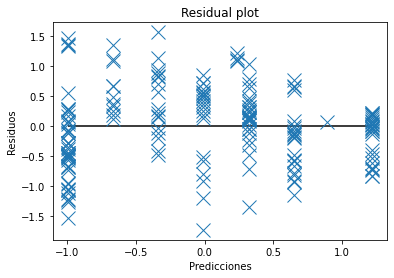

### Resultados
Se evaluó un modelo con 2 features (más el término constante)
#### Métricas
- **TSS:** 182.99999999999994
- **RSS:** 75.0009676200464
- **R^2:** 0.5901586468849922
- **R^2 ajustado:** 0.5832897973914446
#### Coeficientes de X:
- **int_status:** _0.21695587219595885_
- **int_region:** _0.6479055356798327_
- **k:** _-7.574693109159236e-16_
#### VIF
- **int_status**: 1.238199875609936
- **int_region**: 1.238199875609936


In [3]:
region_int_mapping = {
    # Orden basado en las densidades máximas vistas durante el análisis de los datos
    'Africa': 0,
    'South-East Asia': 1,
    'Western Pacific': 2,
    'Eastern Mediterranean': 3,
    'Americas': 4,
    'Europe': 5
}
df['int_status'] = df['Status'].apply(lambda x: 0 if x=='Developing' else 1)
df['int_region'] = df['Region'].apply(lambda x: region_int_mapping[x])
probar_modelo(df[['int_status', 'int_region']])

El residualplot no está muy bueno... Veamos de agregar el acceso a agua potable.

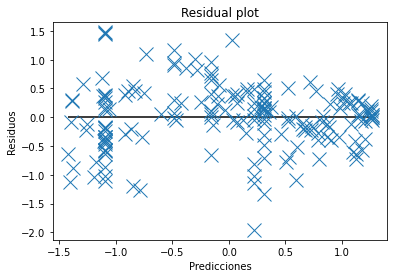

### Resultados
Se evaluó un modelo con 3 features (más el término constante)
#### Métricas
- **TSS:** 182.99999999999994
- **RSS:** 54.93341306448464
- **R^2:** 0.6998174149481714
- **R^2 ajustado:** 0.6930717388795911
#### Coeficientes de X:
- **int_status:** _0.07070650806561095_
- **int_region:** _0.17085933651754426_
- **Population using safely managed drinking-water services (%):** _0.6479366501618419_
- **k:** _-6.556417714835739e-16_
#### VIF
- **int_status**: 1.4332492718990475
- **int_region**: 3.313483778161791
- **Population using safely managed drinking-water services (%)**: 3.8284389842959685


In [4]:
probar_modelo(df[['int_status', 'int_region', 'Population using safely managed drinking-water services (%)']])

Agregar un dato más _"de verdad"_ hizo que tome el mayor coeficiente de los tres XXXXXXXXXXXXXXXXXXXXXXXXXXx

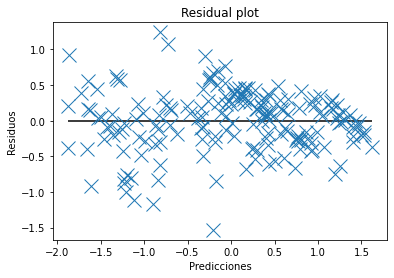

### Resultados
Se evaluó un modelo con 4 features (más el término constante)
#### Métricas
- **TSS:** 182.99999999999994
- **RSS:** 32.93366402805322
- **R^2:** 0.8200346227975234
- **R^2 ajustado:** 0.8149508550799394
#### Coeficientes de X:
- **int_status:** _-0.07915854758987188_
- **Population using safely managed drinking-water services (%):** _0.4613004431488617_
- **Estimated road traffic death rate:** _-0.2999001527545846_
- **Schooling:** _0.3255877808006731_
- **k:** _-6.79165294601937e-16_
#### VIF
- **int_status**: 1.5954437508305384
- **Population using safely managed drinking-water services (%)**: 2.3295460613703742
- **Estimated road traffic death rate**: 1.791729732606496
- **Schooling**: 2.3199300808450833


In [5]:
probar_modelo(df[['int_status', 'Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling']])

Probamos cambiar la variable categorica buscando obtener un mejor resultado.
Usamos HIV/AIDS la cual no tiene alta correlacion con las otras variables.

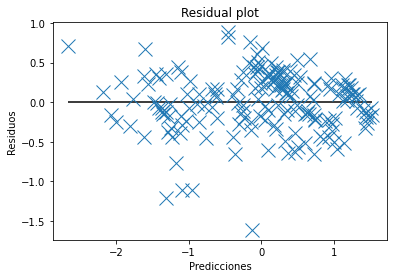

### Resultados
Se evaluó un modelo con 4 features (más el término constante)
#### Métricas
- **TSS:** 182.99999999999994
- **RSS:** 25.483462787920764
- **R^2:** 0.8607461049840396
- **R^2 ajustado:** 0.8568123791361311
#### Coeficientes de X:
- **Population using safely managed drinking-water services (%):** _0.34114386346114517_
- **Estimated road traffic death rate:** _-0.1912873593537976_
- **Schooling:** _0.36788661577854265_
- **HIV/AIDS:** _-0.25064937052591774_
- **k:** _-7.44825337791136e-16_
#### VIF
- **Population using safely managed drinking-water services (%)**: 2.4525785730199123
- **Estimated road traffic death rate**: 1.9357575369629558
- **Schooling**: 2.299872142186231
- **HIV/AIDS**: 1.4074051433322088


In [6]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS']])

Notamos un gran aumento del R2, vamos a ver la diferencia con este modelo dejando la variable categorica.

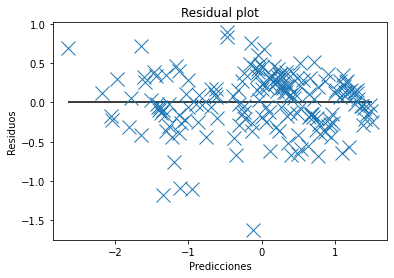

### Resultados
Se evaluó un modelo con 5 features (más el término constante)
#### Métricas
- **TSS:** 182.99999999999994
- **RSS:** 25.285215107917832
- **R^2:** 0.8618294256397933
- **R^2 ajustado:** 0.8571190651502407
#### Coeficientes de X:
- **int_status:** _-0.04200193636055655_
- **Population using safely managed drinking-water services (%):** _0.35399561436660204_
- **Estimated road traffic death rate:** _-0.20112829293464876_
- **Schooling:** _0.37744924439850513_
- **HIV/AIDS:** _-0.2450308459058752_
- **k:** _-7.410627314801623e-16_
#### VIF
- **int_status**: 1.6284768952446131
- **Population using safely managed drinking-water services (%)**: 2.6050426661382966
- **Estimated road traffic death rate**: 2.0251530204039523
- **Schooling**: 2.3842828525679125
- **HIV/AIDS**: 1.436545009482051


In [7]:
probar_modelo(df[['int_status', 'Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS']])

Vemos que la diferencia es minima, con el costo de agregar una variable. Decidimos descartarla.
Queremos agregar alguna variable del grupo de vacunas, probamos con Diphtheria.

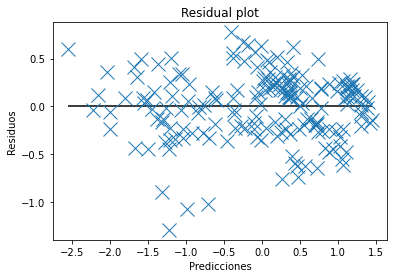

### Resultados
Se evaluó un modelo con 5 features (más el término constante)
#### Métricas
- **TSS:** 182.99999999999994
- **RSS:** 21.911310595069992
- **R^2:** 0.8802660623220218
- **R^2 ajustado:** 0.8761842235375452
#### Coeficientes de X:
- **Population using safely managed drinking-water services (%):** _0.27690970654808766_
- **Estimated road traffic death rate:** _-0.18401637536803755_
- **Schooling:** _0.3072237502796338_
- **HIV/AIDS:** _-0.2554499817781851_
- **Diphtheria:** _0.18317246071255106_
- **k:** _-6.713782204451218e-16_
#### VIF
- **Population using safely managed drinking-water services (%)**: 2.6639533646186
- **Estimated road traffic death rate**: 1.9384659039540206
- **Schooling**: 2.4883962863132334
- **HIV/AIDS**: 1.4085857744164045
- **Diphtheria**: 1.7188639187343315


In [8]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS', 'Diphtheria']])

Logramos un mejor resultado, pero el numero de variables se volvio bastante alto. 
¿Que pasa si siguimos agregando features?

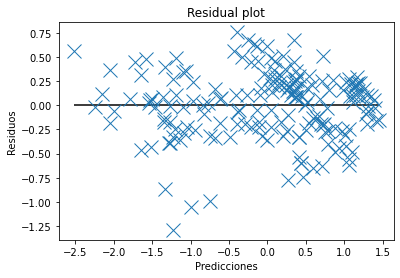

### Resultados
Se evaluó un modelo con 6 features (más el término constante)
#### Métricas
- **TSS:** 182.99999999999994
- **RSS:** 21.808852677221502
- **R^2:** 0.8808259416545273
- **R^2 ajustado:** 0.8760589793207084
#### Coeficientes de X:
- **Population using safely managed drinking-water services (%):** _0.2756420004589383_
- **Estimated road traffic death rate:** _-0.1888804588613068_
- **Schooling:** _0.2985526878107081_
- **HIV/AIDS:** _-0.2531891823499949_
- **Diphtheria:** _0.11587443058658298_
- **Polio:** _0.07574277300152146_
- **k:** _-6.98110549566815e-16_
#### VIF
- **Population using safely managed drinking-water services (%)**: 2.6668237665698102
- **Estimated road traffic death rate**: 1.980723774276935
- **Schooling**: 2.62268830242241
- **HIV/AIDS**: 1.4177149094956245
- **Diphtheria**: 9.808151370315514
- **Polio**: 10.246793065726349


In [9]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS', 'Diphtheria', 'Polio']])

Notamos que agregando Polio comienza a disminuir el R2 ajustado. Como Polio y Diphtheria tienen una correlacion muy alta entre si esto tiene sentido. Probamos con 'Age-standardized suicide rates', tiene poca correlacion con la expectativa de vida, pero tambien la tiene con las otras variables por lo que podria sumar.

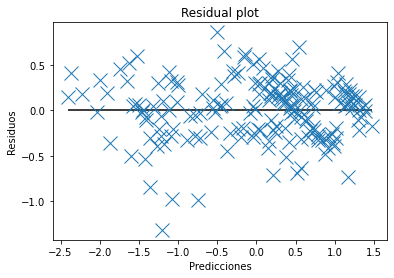

### Resultados
Se evaluó un modelo con 6 features (más el término constante)
#### Métricas
- **TSS:** 182.99999999999994
- **RSS:** 19.901534318788464
- **R^2:** 0.8912484463454182
- **R^2 ajustado:** 0.886898384199235
#### Coeficientes de X:
- **Population using safely managed drinking-water services (%):** _0.2662690898031352_
- **Estimated road traffic death rate:** _-0.16483290146482496_
- **Schooling:** _0.3339771225295822_
- **HIV/AIDS:** _-0.22430171918174746_
- **Diphtheria:** _0.17609540891345182_
- **Age-standardized suicide rates:** _-0.11375415930991142_
- **k:** _-7.16060958283181e-16_
#### VIF
- **Population using safely managed drinking-water services (%)**: 2.67426284974239
- **Estimated road traffic death rate**: 1.9719746275800798
- **Schooling**: 2.553568194818667
- **HIV/AIDS**: 1.4969285477805248
- **Diphtheria**: 1.7234243731912546
- **Age-standardized suicide rates**: 1.178251346222998


In [10]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS', 'Diphtheria', 'Age-standardized suicide rates']])

Se logro una gran mejora, habria que ver si puede descartarse alguna variable sin modificar notablemente el resultado